In [12]:
from DataLoader import *
from Visualization import *
from EstimateFundamentalMatrix import *
from EssentialMatrixFromFundamentalMatrix import *
from GetInliersRANSAC import *
from ExtractCameraPose import *
from LinearTriangulation import *
from DisambiguateCameraPose import *
import os

# Don't generate pyc codes
sys.dont_write_bytecode = True

In [13]:
dataDirPath = os.getcwd() + '/P3Data/'
images = loadImages(dataDirPath)
# displayImages(images, 5)


In [14]:
K = getCameraParams(dataDirPath)
print(K)

[[531.12215532   0.         407.19255084]
 [  0.         531.5417375  313.30871505]
 [  0.           0.           1.        ]]


In [15]:
featureMatchesList = parseMatchFiles(dataDirPath)

In [16]:
InlierList, OutlierList = ransac(featureMatchesList[0].matchPairs, 1000, 0.02)
matchPairsInliers = [featureMatchesList[0].matchPairs[i] for i in InlierList]
matchPairsOutliers = [featureMatchesList[0].matchPairs[i] for i in OutlierList]


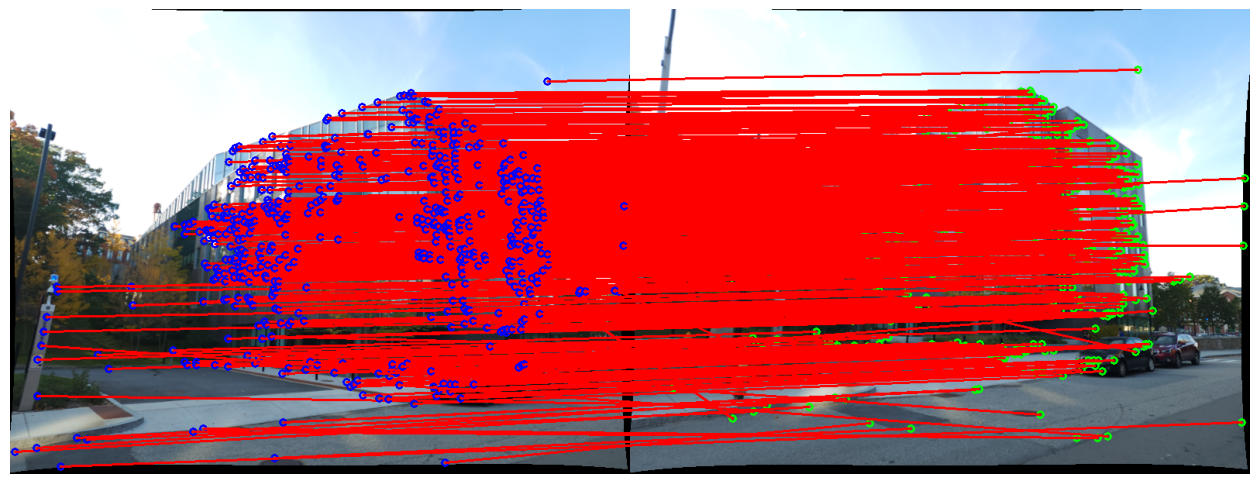

In [17]:
matchImage = drawMatchs(images[0], images[1], matchPairsInliers)

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.imshow(matchImage)
plt.show()

## Final Fundimental Matrix Calculated from inliers

In [18]:
x1s = []
x2s = []
for idx in range(len(matchPairsInliers)):
    x1s.append(matchPairsInliers[idx].coords1)
    x2s.append(matchPairsInliers[idx].coords2)
x1s = np.array(x1s)
x2s = np.array(x2s)

Fest = EstimateFundamentalMatrix(x1s, x2s)
print(Fest)

[[-1.50216677e-06  7.67150871e-07  1.69839222e-04]
 [-3.54063673e-06 -2.53449822e-06  2.74294631e-03]
 [ 2.22088000e-03  2.54079547e-04 -9.99993725e-01]]


## Estimate Essential Matrix from Fundimental Matrix

In [19]:
Eest = EssentialFromFundamental(Fest, K)
print(Eest)

[[-0.59991404  0.55678538 -0.25792592]
 [-0.70996804 -0.65659006  0.25441907]
 [ 0.36743281 -0.32524689  0.15126405]]


## Estimate Camera Pose

In [20]:
Rest, Test = extractCameraPose(Eest)
print(Rest)
print(Test)

[array([[-0.62956916, -0.35919618,  0.68892727],
       [ 0.7030868 , -0.64072755,  0.30844312],
       [ 0.3306231 ,  0.67856194,  0.65592839]]), array([[-0.62956916, -0.35919618,  0.68892727],
       [ 0.7030868 , -0.64072755,  0.30844312],
       [ 0.3306231 ,  0.67856194,  0.65592839]]), array([[ 0.59643023,  0.76094529,  0.25540798],
       [-0.70375082,  0.64877758, -0.28952104],
       [-0.38601265, -0.00706448,  0.92246644]]), array([[ 0.59643023,  0.76094529,  0.25540798],
       [-0.70375082,  0.64877758, -0.28952104],
       [-0.38601265, -0.00706448,  0.92246644]])]
[array([-0.51338816, -0.01028699, -0.85809485]), array([0.51338816, 0.01028699, 0.85809485]), array([-0.51338816, -0.01028699, -0.85809485]), array([0.51338816, 0.01028699, 0.85809485])]


## Triangulation Check for Cheirality Condition

In [21]:
Xest = []
for i in range(len(Rest)):
    X = LinearTriangulation(K, x1s, x2s, np.eye(3), np.zeros((3,1)), Rest[i], Test[i])
    Xest.append(X)

Rest, Test, Xest = disambiguateCameraPose(Rest, Test, Xest)


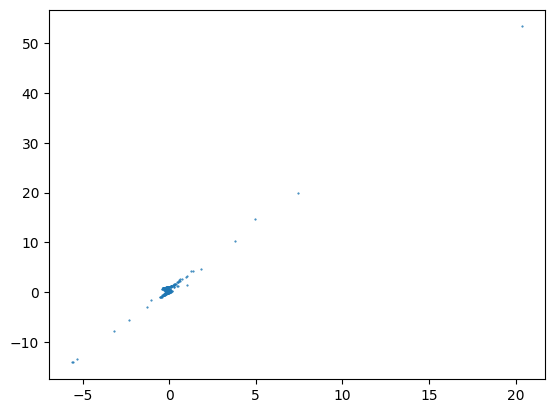

In [22]:
drawWorldPoints([Xest])
# drawWorldPoints(Xest)
# drawWorldPoints([Xest[0]])
# drawWorldPoints([Xest[1]])
# drawWorldPoints([Xest[2]])
# drawWorldPoints([Xest[3]])